In [1]:
import matplotlib.pyplot as plt
from ipywidgets import *
import numpy as np
import sys
import taurex.log
taurex.log.disableLogging()
from taurex.cache import OpacityCache,CIACache

np.random.seed(1234)

# Generate a transmission spectrum

At first we define the planetary and stellar parameters of WASP-62b. We then randomize the H2O, CH4, CO2, CO abundances within $[10^{-8}, 10^{-2}]$.

In [2]:
path_to_data = '/home/ubuntu'

OpacityCache().clear_cache()
OpacityCache().set_opacity_path(f"{path_to_data}/atmosphere/xsecs")
CIACache().set_cia_path(f"{path_to_data}/atmosphere/cia/hitran")

T_irr=1415.0
planet_mass=0.58
planet_radius=1.39
star_temperature=6230.0
star_radius=1.28

from taurex.temperature import Guillot2010
guillot = Guillot2010(T_irr=T_irr)

from taurex.planet import Planet
planet = Planet(planet_radius=planet_radius,planet_mass=planet_mass)

from taurex.stellar import BlackbodyStar

star = BlackbodyStar(temperature=star_temperature,radius=star_radius)

from taurex.chemistry import TaurexChemistry
chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=0.172)

from taurex.chemistry import ConstantGas
H2O=10**np.random.uniform(-2,-8)
CH4=10**np.random.uniform(-2,-8)
CO2=10**np.random.uniform(-2,-8)
CO=10**np.random.uniform(-2,-8)

chemistry.addGas(ConstantGas('H2O',mix_ratio=H2O))
chemistry.addGas(ConstantGas('CH4',mix_ratio=CH4))
chemistry.addGas(ConstantGas('CO2',mix_ratio=CO2))
chemistry.addGas(ConstantGas('CO',mix_ratio=CO))

Numba not installed, using numpy instead


In [3]:
print(f'True stellar parameter values: \n \
T_irr = {T_irr} \n \
planet_mass = {planet_mass} \n \
planet_radius = {planet_radius} \n \
logH20 = {np.log10(H2O)} \n \
logCH4 = {np.log10(CH4)} \n \
logCO2 = {np.log10(CO2)} \n logCO = {np.log10(CO)} ')

True stellar parameter values: 
 T_irr = 1415.0 
 planet_mass = 0.58 
 planet_radius = 1.39 
 logH20 = -3.1491167022733535 
 logCH4 = -5.732652626238991 
 logCO2 = -4.626366434042687 
 logCO = -6.712151502282615 


We then define and build the model:

In [4]:
from taurex.model import TransmissionModel
tm = TransmissionModel(planet=planet,
                       temperature_profile=guillot,
                       chemistry=chemistry,
                       star=star,
                        atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)

from taurex.contributions import AbsorptionContribution
tm.add_contribution(AbsorptionContribution())

from taurex.contributions import CIAContribution
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))

from taurex.contributions import RayleighContribution
tm.add_contribution(RayleighContribution())

In [5]:
tm.build()
res = tm.model()

<span style="color: red;">Descrivere il plot qui sotto</span>

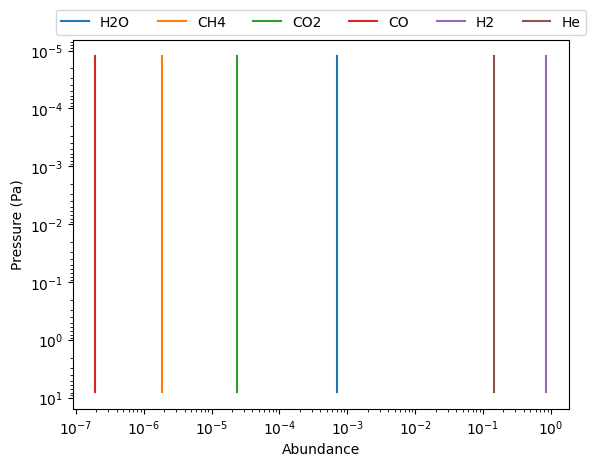

In [6]:
plt.figure()

for x,gasname in enumerate(tm.chemistry.activeGases):
    plt.plot(tm.chemistry.activeGasMixProfile[x],tm.pressureProfile/1e5,label=gasname)

for x,gasname in enumerate(tm.chemistry.inactiveGases):
    plt.plot(tm.chemistry.inactiveGasMixProfile[x],tm.pressureProfile/1e5,label=gasname)
    
plt.gca().invert_yaxis()
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Abundance')
plt.ylabel('Pressure (Pa)')
plt.legend(ncols=6, loc='upper center', bbox_to_anchor=(0.5, 1.1))
plt.show()

We proceed by plotting the generated transmission spectrum:

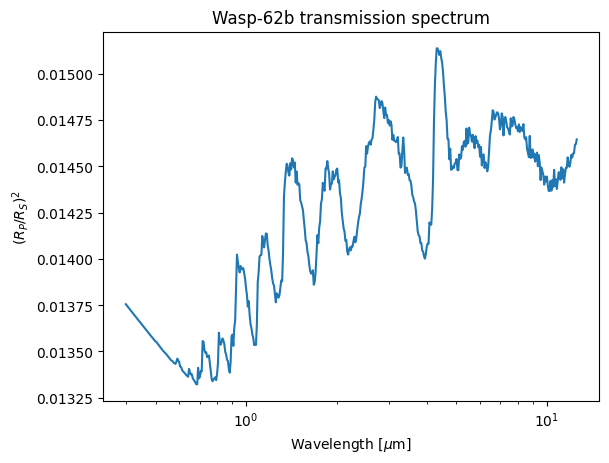

In [7]:
from taurex.binning import FluxBinner,SimpleBinner
binned_fig = plt.figure()

#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.4,1.1,500))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_rprs,_,_  = bn.bin_model(tm.model(wngrid=wngrid))

plt.title('Wasp-62b transmission spectrum')
plt.plot(10000/bin_wn,bin_rprs)
plt.xscale('log')
plt.xlabel('Wavelength [$\mu$m]')
plt.ylabel('$(R_{P}/R_{S})^{2}$')
plt.show()

In [8]:
# now we make a .dat file in which the data of the spectrum are stored, then we write the abundances of the various active gases:

wn = np.array(10000/bin_wn)
bin_rprs_square_root = bin_rprs**0.5
errors = 1e-5*np.ones(shape = bin_rprs.shape)

np.savetxt('WASP_62b_assignment3_taskA_spectrum.dat', np.column_stack([wn,bin_rprs,bin_rprs_square_root]), header='Wavelength, (Rp/Rs)^2, Rp/Rs', delimiter='\t')
np.savetxt('WASP_62b_synthetic_spectrum.dat', np.column_stack([wn,bin_rprs,errors]), header='Wavelength, (Rp/Rs)^2, err', delimiter='\t')